In [34]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.pyplot import imread
import nltk
from imblearn.over_sampling import RandomOverSampler
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import f1_score, accuracy_score
from nltk.tokenize import word_tokenize
import codecs
from tqdm import tqdm
import shutil
import pickle




from sklearn.model_selection import train_test_split
from imblearn.over_sampling import RandomOverSampler
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential
from keras.layers import LSTM, GRU,SimpleRNN
from keras.layers import Dense, Activation, Dropout
from keras.layers import Embedding
from keras.layers import BatchNormalization
from keras.utils import to_categorical
from sklearn import preprocessing, decomposition, model_selection, metrics, pipeline
from keras.layers import GlobalMaxPooling1D, Conv1D, MaxPooling1D, Flatten, Bidirectional, SpatialDropout1D
from keras.callbacks import EarlyStopping
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, KFold
from imblearn.over_sampling import SMOTE
from tensorflow.keras.preprocessing.text import Tokenizer, one_hot
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout
from tensorflow.keras.optimizers import Adam
import tensorflow as tf
from sklearn.metrics import precision_score, recall_score, f1_score, classification_report, confusion_matrix, roc_curve, auc
from sklearn.utils.class_weight import compute_class_weight
import matplotlib.pyplot as plt
import seaborn as sns
from nltk.stem.porter import PorterStemmer

import re
import warnings
warnings.filterwarnings("ignore")

In [35]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
train_cleaned_data = pd.read_csv("drive/MyDrive/Colab Notebooks/data/train_cleaned_rnn.csv")
test_cleaned_data = pd.read_csv("drive/MyDrive/Colab Notebooks/data/test_cleaned_rnn.csv")

X_train_data = train_cleaned_data['tweet_cleaned']
y_train_data = train_cleaned_data['label']

X_test_data = test_cleaned_data['tweet_cleaned']
y_test_data = test_cleaned_data['label']


### Textvorverarbeitung

In [ ]:
def one_hot_enc(X_data, y_data):
  corpus = [str(text) for text in X_data]
  vocab_size = 5000

  #one hot encoding
  one_hot_dir = [one_hot(words,vocab_size) for words in corpus]

  embedded_layer = pad_sequences(one_hot_dir,padding = 'pre')
  return np.array(embedded_layer), np.array(y_data)

In [36]:
def tokenize(X_data, y_data, tokenizer=None, max_len=40):
    X_data = [str(x) for x in X_data]

    # # Wenn kein Tokenizer bereitgestellt wird, erstelle einen neuen
    if tokenizer is None:
        tokenizer = Tokenizer(num_words=None, oov_token="<OOV>")
        tokenizer.fit_on_texts(X_data)

    # # Tokenisierung
    X_data_sequences = tokenizer.texts_to_sequences(X_data)

    X_data_padded_sequences = pad_sequences(X_data_sequences, padding='post', maxlen=max_len)
    return X_data_padded_sequences, y_data, tokenizer


### Sampling

In [ ]:
def random_over_sample(X_data, y_data):
  ros = RandomOverSampler(random_state=42)
  X = X_data.values.reshape(-1, 1)
  y = y_data.values

  X_resampled, y_resampled = ros.fit_resample(X, y)
  X_resampled = X_resampled[:, 0]
  return X_resampled, y_resampled


### Embeddings

In [37]:
def load_embeddings(file_path, embedding_dim, word_index):
    embedding_index = {}
    with open(file_path, encoding='utf-8') as f:
        for line in f:
            values = line.rstrip().split(' ')
            word = values[0]
            coefs = np.asarray(values[1:], dtype='float32')
            embedding_index[word] = coefs

    embedding_matrix = np.zeros((len(word_index) + 1, embedding_dim))
    for word, i in word_index.items():
        embedding_vector = embedding_index.get(word)
        if embedding_vector is not None:
            embedding_matrix[i] = embedding_vector

    return embedding_matrix

In [ ]:
import requests, zipfile, io
zip_file_url = "http://nlp.stanford.edu/data/glove.6B.zip"
r = requests.get(zip_file_url)
z = zipfile.ZipFile(io.BytesIO(r.content))
z.extractall()

In [ ]:
import requests, zipfile, io
zip_file_url = "https://dl.fbaipublicfiles.com/fasttext/vectors-english/wiki-news-300d-1M.vec.zip"
r = requests.get(zip_file_url)
z = zipfile.ZipFile(io.BytesIO(r.content))
z.extractall()

### Model

In [38]:
def train_gru(x_train, y_train, x_val, y_val, vocab_size, max_len, embedding_matrix=None, embedding_dim=200, epochs=20, batch_size=32):
    model = Sequential()
    if embedding_matrix is not None:
        model.add(Embedding(vocab_size, embedding_dim, weights=[embedding_matrix], input_length=max_len, trainable=False))
    else:
        model.add(Embedding(vocab_size, embedding_dim, input_length=max_len))
    model.add(SpatialDropout1D(0.35))
    model.add(GRU(256))
    model.add(Dense(1, activation='sigmoid'))
    model.compile(loss='binary_crossentropy', optimizer=Adam(), metrics=['accuracy', 'Recall'])


    history = model.fit(x_train, y_train, epochs=epochs, batch_size=batch_size, validation_data=(x_val, y_val))
    return model, history


### Evaluation

In [39]:
def evaluate_on_val(model, history, X_val, y_val, threshold=0.35):
    """
    Evaluates the model on validation data with detailed metrics and visualizes training performance.

    Parameters:
    - model: Trained model to evaluate.
    - history: Training history object.
    - X_val: Validation data (features).
    - y_val: Validation data (labels).
    - threshold: Decision threshold to classify an instance as positive.

    Returns:
    None
    """
    # Plot Training and Validation Metrics
    plt.figure(figsize=(12, 6))

    # Accuracy
    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'], label='Training Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.title('Model Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()

    # Loss
    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'], label='Training Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title('Model Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

    plt.tight_layout()
    plt.show()

    # Evaluate Validation Data
    print("\nValidation Performance:")
    y_val_pred = (model.predict(X_val) > threshold).astype(int)

    accuracy = accuracy_score(y_val, y_val_pred)
    precision = precision_score(y_val, y_val_pred)
    recall = recall_score(y_val, y_val_pred)
    f1 = f1_score(y_val, y_val_pred)

    print(f"Accuracy: {accuracy:.4f}")
    print(f"Precision: {precision:.4f}")
    print(f"Recall: {recall:.4f}")
    print(f"F1 Score: {f1:.4f}")

    print("\nClassification Report:")
    print(classification_report(y_val, y_val_pred))

    # Confusion Matrix
    conf_matrix = confusion_matrix(y_val, y_val_pred)
    plt.figure(figsize=(8, 6))
    sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=['No Hate Speech', 'Hate Speech'], yticklabels=['No Hate Speech', 'Hate Speech'])
    plt.title('Confusion Matrix - Validation Data')
    plt.xlabel('Predicted Labels')
    plt.ylabel('True Labels')
    plt.show()


In [40]:
def evaluate_on_test(model, X_test, y_test, threshold=0.35):
    """
    Evaluates the model on an independent test dataset with detailed metrics.

    Parameters:
    - model: Trained model to evaluate.
    - X_test: Test data (features).
    - y_test: Test data (labels).
    - threshold: Decision threshold to classify an instance as positive.

    Returns:
    None
    """
    print("\nTest Performance:")
    y_test_pred = (model.predict(X_test) > threshold).astype(int)

    accuracy = accuracy_score(y_test, y_test_pred)
    precision = precision_score(y_test, y_test_pred)
    recall = recall_score(y_test, y_test_pred)
    f1 = f1_score(y_test, y_test_pred)

    print(f"Accuracy: {accuracy:.4f}")
    print(f"Precision: {precision:.4f}")
    print(f"Recall: {recall:.4f}")
    print(f"F1 Score: {f1:.4f}")

    print("\nClassification Report:")
    print(classification_report(y_test, y_test_pred))

    # Confusion Matrix
    conf_matrix = confusion_matrix(y_test, y_test_pred)
    plt.figure(figsize=(8, 6))
    sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Greens', xticklabels=['No Hate Speech', 'Hate Speech'], yticklabels=['No Hate Speech', 'Hate Speech'])
    plt.title('Confusion Matrix - Test Data')
    plt.xlabel('Predicted Labels')
    plt.ylabel('True Labels')
    plt.show()


### Training/Evaluate

In [ ]:
def one_hot_and_split_data(X_train_data, y_train_data, X_test_data, y_test_data):
  X_gru, y_gru = one_hot_enc(X_train_data, y_train_data)
  X_train_gru,X_val_gru,y_train_gru,y_val_gru=train_test_split(X_gru,y_gru,test_size=0.2,random_state=0)
  X_test_gru, y_test_gru = one_hot_enc(X_test_data, y_test_data)
  return X_train_gru, X_val_gru, y_train_gru, y_val_gru, X_test_gru, y_test_gru

In [41]:
def tokenize_and_split_data(X_train_data, y_train_data, X_test_data, y_test_data):
  X_gru, y_gru, tokenizer = tokenize(X_train_data, y_train_data)
  X_train_gru,X_val_gru,y_train_gru,y_val_gru=train_test_split(X_gru,y_gru,test_size=0.2,random_state=42)
  X_test_gru, y_test_gru, _= tokenize(X_test_data, y_test_data, tokenizer)
  return X_train_gru, X_val_gru, y_train_gru, y_val_gru, X_test_gru, y_test_gru, tokenizer

##### One-Hot

Epoch 1/10
508/508 ━━━━━━━━━━━━━━━━━━━━ 18s 18ms/step - Recall: 0.0522 - accuracy: 0.9318 - loss: 0.2479 - val_Recall: 0.1597 - val_accuracy: 0.9441 - val_loss: 0.1722
Epoch 2/10
508/508 ━━━━━━━━━━━━━━━━━━━━ 9s 17ms/step - Recall: 0.5142 - accuracy: 0.9602 - loss: 0.1071 - val_Recall: 0.4753 - val_accuracy: 0.9411 - val_loss: 0.1604
Epoch 3/10
508/508 ━━━━━━━━━━━━━━━━━━━━ 10s 18ms/step - Recall: 0.7695 - accuracy: 0.9795 - loss: 0.0593 - val_Recall: 0.5589 - val_accuracy: 0.9315 - val_loss: 0.1994
Epoch 4/10
508/508 ━━━━━━━━━━━━━━━━━━━━ 10s 18ms/step - Recall: 0.8891 - accuracy: 0.9874 - loss: 0.0343 - val_Recall: 0.4639 - val_accuracy: 0.9396 - val_loss: 0.2373
Epoch 5/10
508/508 ━━━━━━━━━━━━━━━━━━━━ 9s 18ms/step - Recall: 0.9403 - accuracy: 0.9943 - loss: 0.0170 - val_Recall: 0.3650 - val_accuracy: 0.9433 - val_loss: 0.3023
Epoch 6/10
508/508 ━━━━━━━━━━━━━━━━━━━━ 10s 18ms/step - Recall: 0.9498 - accuracy: 0.9952 - loss: 0.0139 - val_Recall: 0.4525 - val_accuracy: 0.9337 - val_loss: 0

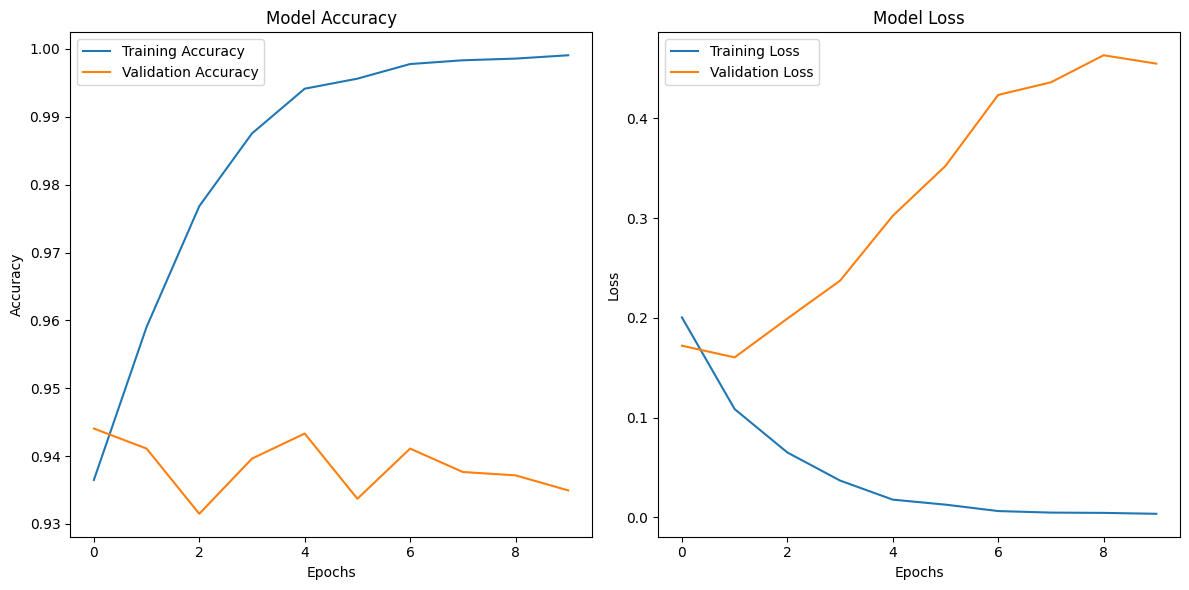


Validation Performance:
127/127 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step
Accuracy: 0.9317
Precision: 0.4713
Recall: 0.4373
F1 Score: 0.4536

Classification Report:
              precision    recall  f1-score   support

           0       0.96      0.97      0.96      3795
           1       0.47      0.44      0.45       263

    accuracy                           0.93      4058
   macro avg       0.72      0.70      0.71      4058
weighted avg       0.93      0.93      0.93      4058



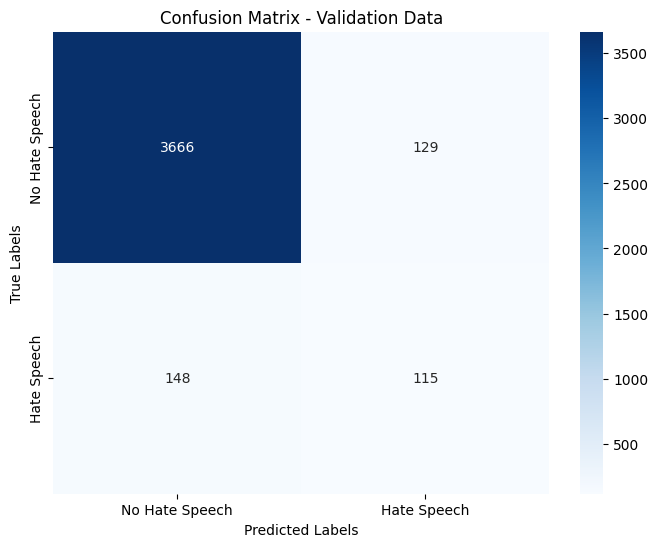


Test Performance:
285/285 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step
Accuracy: 0.9407
Precision: 0.5840
Recall: 0.4784
F1 Score: 0.5259

Classification Report:
              precision    recall  f1-score   support

           0       0.96      0.97      0.97      8468
           1       0.58      0.48      0.53       625

    accuracy                           0.94      9093
   macro avg       0.77      0.73      0.75      9093
weighted avg       0.94      0.94      0.94      9093



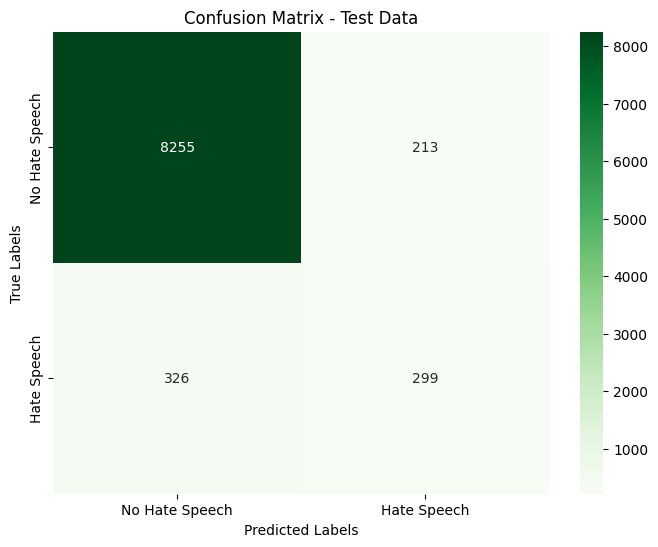

In [ ]:
X_train_onehot,X_val_onehot,y_train_onehot,y_val_onehot, X_test_onehot, y_test_onehot = one_hot_and_split_data(X_train_data, y_train_data, X_test_data, y_test_data)
model, history = train_gru(X_train_onehot, y_train_onehot, X_val_onehot, y_val_onehot, 5000, len(X_train_onehot[0]), None, embedding_dim=200, epochs=10, batch_size=32)
evaluate_on_val(model, history, X_val_onehot, y_val_onehot)
evaluate_on_test(model, X_test_onehot, y_test_onehot)

##### Tokenize

Epoch 1/20
948/948 ━━━━━━━━━━━━━━━━━━━━ 9s 7ms/step - Recall: 0.6520 - accuracy: 0.7160 - loss: 0.5052 - val_Recall: 0.8090 - val_accuracy: 0.8698 - val_loss: 0.2744
Epoch 2/20
948/948 ━━━━━━━━━━━━━━━━━━━━ 8s 8ms/step - Recall: 0.9033 - accuracy: 0.8793 - loss: 0.2789 - val_Recall: 0.9670 - val_accuracy: 0.9342 - val_loss: 0.1701
Epoch 3/20
948/948 ━━━━━━━━━━━━━━━━━━━━ 9s 7ms/step - Recall: 0.9520 - accuracy: 0.9277 - loss: 0.1868 - val_Recall: 0.9934 - val_accuracy: 0.9653 - val_loss: 0.0961
Epoch 4/20
948/948 ━━━━━━━━━━━━━━━━━━━━ 10s 7ms/step - Recall: 0.9686 - accuracy: 0.9535 - loss: 0.1277 - val_Recall: 0.9974 - val_accuracy: 0.9793 - val_loss: 0.0619
Epoch 5/20
948/948 ━━━━━━━━━━━━━━━━━━━━ 11s 8ms/step - Recall: 0.9823 - accuracy: 0.9696 - loss: 0.0846 - val_Recall: 1.0000 - val_accuracy: 0.9694 - val_loss: 0.0892
Epoch 6/20
948/948 ━━━━━━━━━━━━━━━━━━━━ 7s 7ms/step - Recall: 0.9854 - accuracy: 0.9794 - loss: 0.0616 - val_Recall: 1.0000 - val_accuracy: 0.9902 - val_loss: 0.0348
Ep

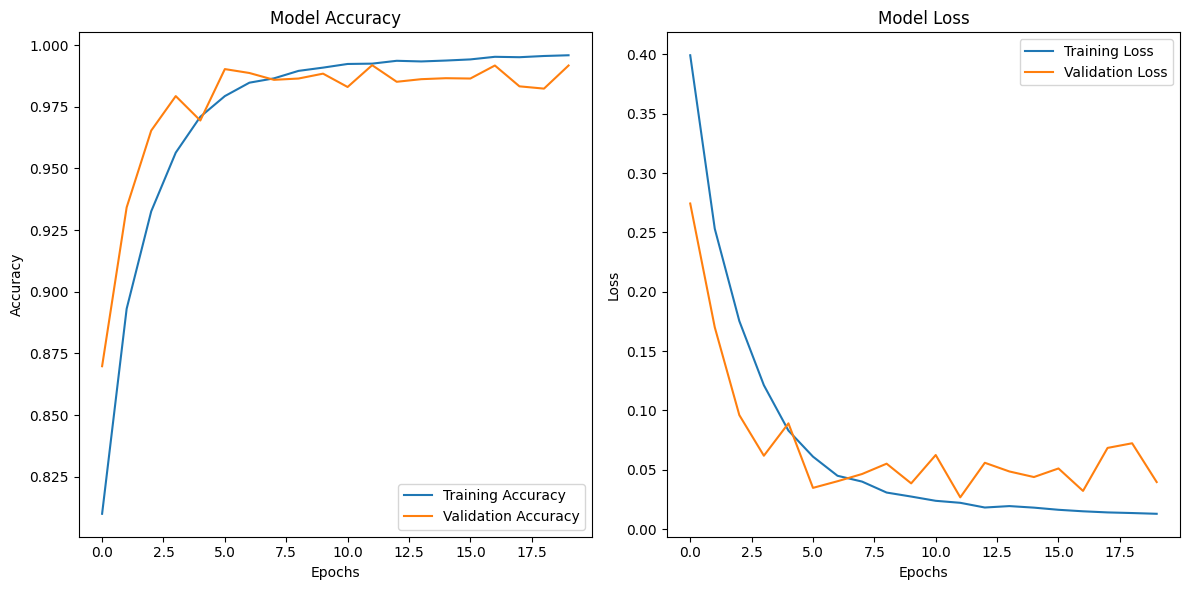


Validation Performance:
237/237 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
Accuracy: 0.9906
Precision: 0.9816
Recall: 1.0000
F1 Score: 0.9907

Classification Report:
              precision    recall  f1-score   support

           0       1.00      0.98      0.99      3795
           1       0.98      1.00      0.99      3785

    accuracy                           0.99      7580
   macro avg       0.99      0.99      0.99      7580
weighted avg       0.99      0.99      0.99      7580



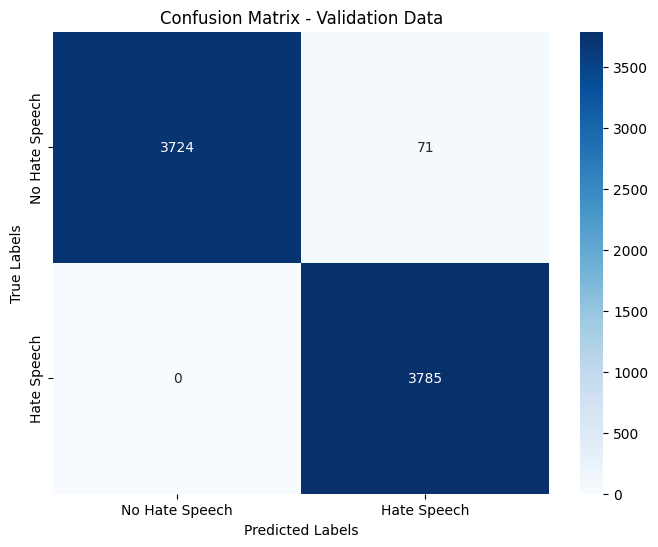


Test Performance:
285/285 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
Accuracy: 0.9555
Precision: 0.7060
Recall: 0.6032
F1 Score: 0.6506

Classification Report:
              precision    recall  f1-score   support

           0       0.97      0.98      0.98      8468
           1       0.71      0.60      0.65       625

    accuracy                           0.96      9093
   macro avg       0.84      0.79      0.81      9093
weighted avg       0.95      0.96      0.95      9093



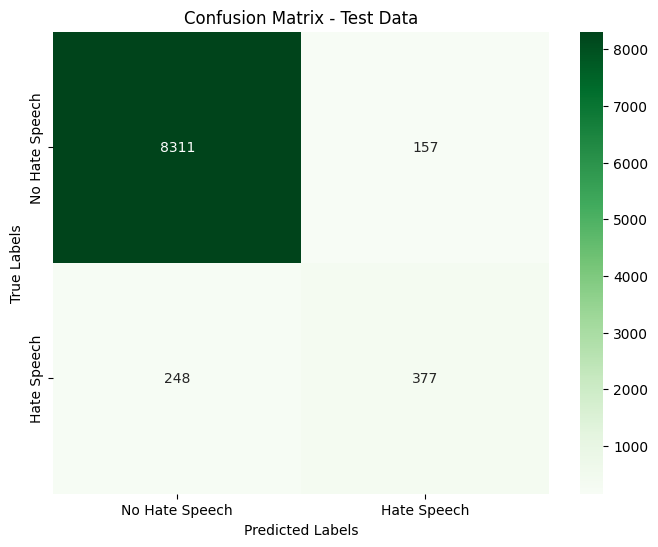

In [ ]:
X_train_token,X_val_token,y_train_token,y_val_token, X_test_token, y_test_token, tokenizer = tokenize_and_split_data(X_train_data, y_train_data, X_test_data, y_test_data)
glove_embedding_matrix = load_embeddings('drive/MyDrive/Colab Notebooks/data/embeddings/glove.twitter.27B.200d.txt', 200, tokenizer.word_index)
model, history = train_gru(X_train_token, y_train_token, X_val_token, y_val_token, len(tokenizer.word_index)+1, 40, glove_embedding_matrix, embedding_dim=200, epochs=20, batch_size=32)
evaluate_on_val(model, history, X_val_token, y_val_token)
evaluate_on_test(model, X_test_token, y_test_token)

In [ ]:
model.save("drive/MyDrive/Colab Notebooks/models/gru/old/gru-model_old-dataset.keras")

with open("drive/MyDrive/Colab Notebooks/models/gru/old/tokenizer_old-dataset.pkl", 'wb') as f:
    pickle.dump(tokenizer, f)


## Modelloptimierung durch neuen Datensatz + Sampling

In [ ]:
new_train_cleaned_data = pd.read_csv("drive/MyDrive/Colab Notebooks/data/new_train_cleaned_rnn.csv")
new_test_cleaned_data = pd.read_csv("drive/MyDrive/Colab Notebooks/data/new_test_cleaned_rnn.csv")


X_new_train_data = new_train_cleaned_data['tweet_cleaned']
y_new_train_data = new_train_cleaned_data['label']

X_new_test_data = new_test_cleaned_data['tweet_cleaned']
y_new_test_data = new_test_cleaned_data['label']


Epoch 1/15
2480/2480 ━━━━━━━━━━━━━━━━━━━━ 22s 8ms/step - Recall: 0.6179 - accuracy: 0.6211 - loss: 0.6286 - val_Recall: 0.6676 - val_accuracy: 0.7489 - val_loss: 0.4993
Epoch 2/15
2480/2480 ━━━━━━━━━━━━━━━━━━━━ 23s 9ms/step - Recall: 0.7599 - accuracy: 0.7555 - loss: 0.4926 - val_Recall: 0.8205 - val_accuracy: 0.7892 - val_loss: 0.4422
Epoch 3/15
2480/2480 ━━━━━━━━━━━━━━━━━━━━ 38s 8ms/step - Recall: 0.8095 - accuracy: 0.7876 - loss: 0.4425 - val_Recall: 0.8403 - val_accuracy: 0.8188 - val_loss: 0.3979
Epoch 4/15
2480/2480 ━━━━━━━━━━━━━━━━━━━━ 25s 10ms/step - Recall: 0.8542 - accuracy: 0.8259 - loss: 0.3834 - val_Recall: 0.9329 - val_accuracy: 0.8365 - val_loss: 0.3726
Epoch 5/15
2480/2480 ━━━━━━━━━━━━━━━━━━━━ 34s 7ms/step - Recall: 0.8744 - accuracy: 0.8464 - loss: 0.3447 - val_Recall: 0.9264 - val_accuracy: 0.8593 - val_loss: 0.3317
Epoch 6/15
2480/2480 ━━━━━━━━━━━━━━━━━━━━ 22s 8ms/step - Recall: 0.8982 - accuracy: 0.8718 - loss: 0.3038 - val_Recall: 0.9229 - val_accuracy: 0.8765 - va

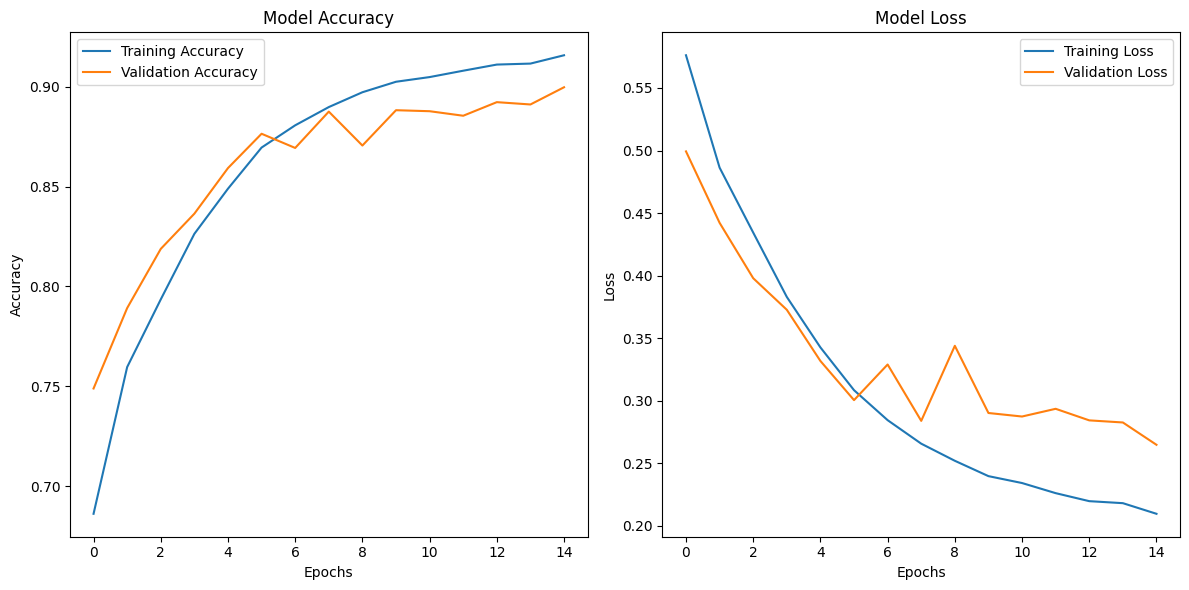


Validation Performance:
620/620 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step
Accuracy: 0.8893
Precision: 0.8364
Recall: 0.9656
F1 Score: 0.8964

Classification Report:
              precision    recall  f1-score   support

           0       0.96      0.81      0.88      9999
           1       0.84      0.97      0.90      9834

    accuracy                           0.89     19833
   macro avg       0.90      0.89      0.89     19833
weighted avg       0.90      0.89      0.89     19833



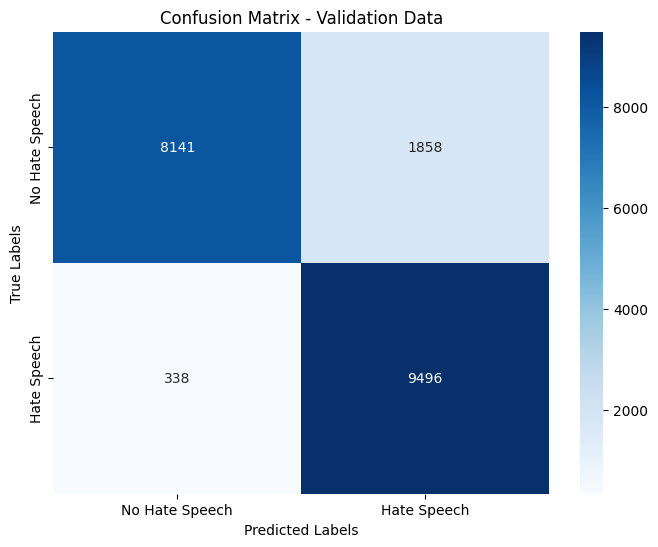


Test Performance:
1654/1654 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step
Accuracy: 0.7884
Precision: 0.6194
Recall: 0.7359
F1 Score: 0.6727

Classification Report:
              precision    recall  f1-score   support

           0       0.88      0.81      0.84     37286
           1       0.62      0.74      0.67     15631

    accuracy                           0.79     52917
   macro avg       0.75      0.77      0.76     52917
weighted avg       0.80      0.79      0.79     52917



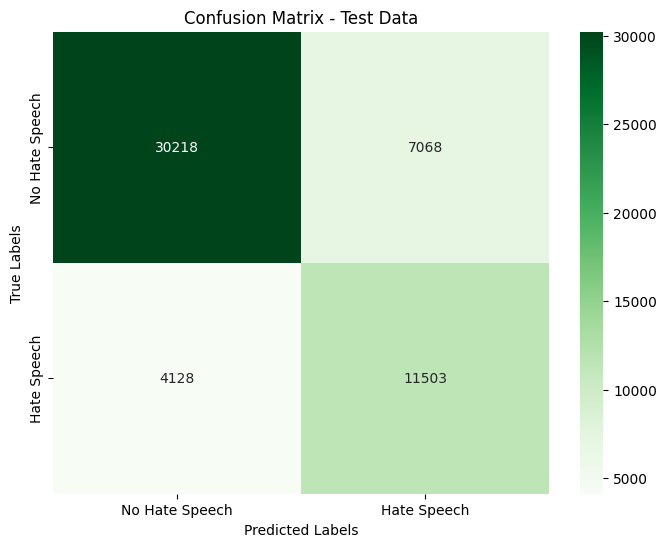

In [ ]:
X_train_token,X_val_token,y_train_token,y_val_token, X_test_token, y_test_token, tokenizer = tokenize_and_split_data(X_new_train_data, y_new_train_data, X_new_test_data, y_new_test_data)
glove_embedding_matrix = load_embeddings('drive/MyDrive/Colab Notebooks/data/embeddings/glove.twitter.27B.200d.txt', 200, tokenizer.word_index)
model, history = train_gru(X_train_token, y_train_token, X_val_token, y_val_token, len(tokenizer.word_index)+1, 40, glove_embedding_matrix, embedding_dim=200, epochs=15, batch_size=32)
evaluate_on_val(model, history, X_val_token, y_val_token)
evaluate_on_test(model, X_test_token, y_test_token)

In [ ]:
model.save("drive/MyDrive/Colab Notebooks/models/gru/new/gru-model_new-dataset.keras")

with open("drive/MyDrive/Colab Notebooks/models/gru/new/tokenizer_new-dataset.pkl", 'wb') as f:
    pickle.dump(tokenizer, f)


## Modelloptimierung durch mixed Datensatz

In [42]:
mixed_train_cleaned_data = pd.read_csv("drive/MyDrive/Colab Notebooks/data/mixed_train_cleaned_rnn.csv")
mixed_test_cleaned_data = pd.read_csv("drive/MyDrive/Colab Notebooks/data/mixed_test_cleaned_rnn.csv")


X_mixed_train_data = mixed_train_cleaned_data['tweet_cleaned']
y_mixed_train_data = mixed_train_cleaned_data['label']

X_mixed_test_data = mixed_test_cleaned_data['tweet_cleaned']
y_mixed_test_data = mixed_test_cleaned_data['label']


Epoch 1/20
2083/2083 ━━━━━━━━━━━━━━━━━━━━ 26s 11ms/step - Recall: 0.0424 - accuracy: 0.8178 - loss: 0.4689 - val_Recall: 0.2623 - val_accuracy: 0.8491 - val_loss: 0.3524
Epoch 2/20
2083/2083 ━━━━━━━━━━━━━━━━━━━━ 19s 9ms/step - Recall: 0.2994 - accuracy: 0.8424 - loss: 0.3588 - val_Recall: 0.2317 - val_accuracy: 0.8504 - val_loss: 0.3443
Epoch 3/20
2083/2083 ━━━━━━━━━━━━━━━━━━━━ 28s 13ms/step - Recall: 0.3488 - accuracy: 0.8537 - loss: 0.3370 - val_Recall: 0.3532 - val_accuracy: 0.8578 - val_loss: 0.3329
Epoch 4/20
2083/2083 ━━━━━━━━━━━━━━━━━━━━ 30s 7ms/step - Recall: 0.3955 - accuracy: 0.8604 - loss: 0.3189 - val_Recall: 0.4508 - val_accuracy: 0.8573 - val_loss: 0.3291
Epoch 5/20
2083/2083 ━━━━━━━━━━━━━━━━━━━━ 19s 9ms/step - Recall: 0.4584 - accuracy: 0.8680 - loss: 0.3039 - val_Recall: 0.4491 - val_accuracy: 0.8599 - val_loss: 0.3255
Epoch 6/20
2083/2083 ━━━━━━━━━━━━━━━━━━━━ 15s 7ms/step - Recall: 0.4882 - accuracy: 0.8748 - loss: 0.2886 - val_Recall: 0.4750 - val_accuracy: 0.8580 - v

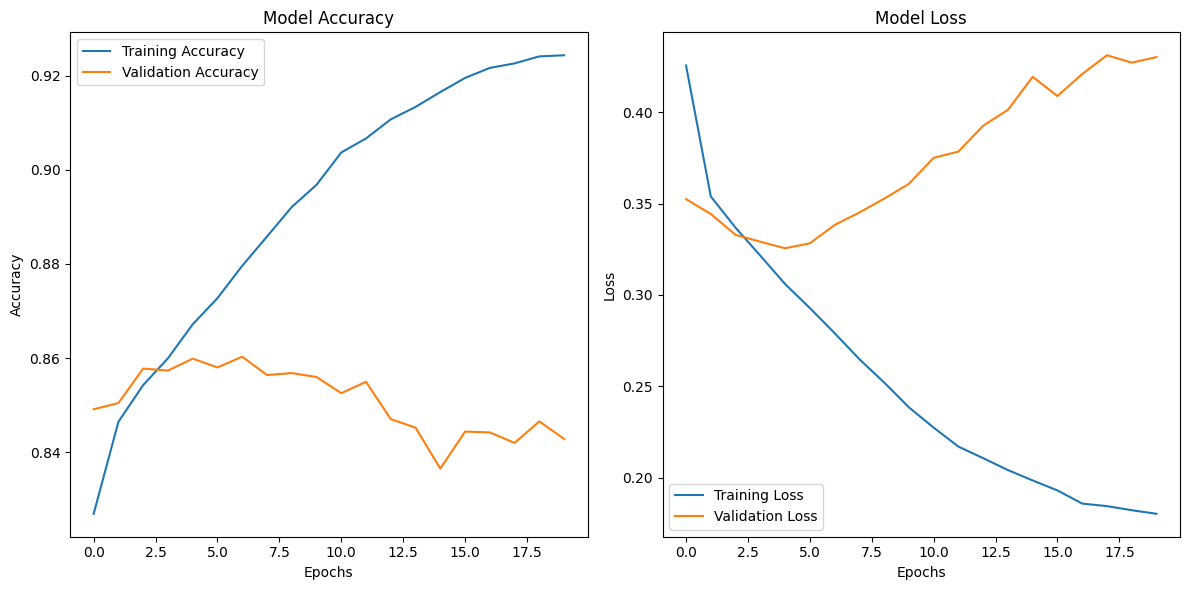


Validation Performance:
521/521 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step
Accuracy: 0.8279
Precision: 0.5107
Recall: 0.5747
F1 Score: 0.5408

Classification Report:
              precision    recall  f1-score   support

           0       0.91      0.88      0.89     13723
           1       0.51      0.57      0.54      2939

    accuracy                           0.83     16662
   macro avg       0.71      0.73      0.72     16662
weighted avg       0.84      0.83      0.83     16662



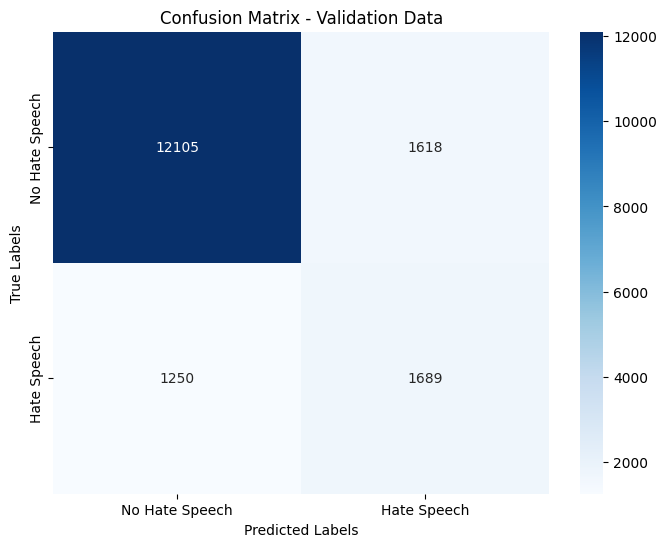


Test Performance:
1019/1019 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step
Accuracy: 0.8039
Precision: 0.5292
Recall: 0.6021
F1 Score: 0.5633

Classification Report:
              precision    recall  f1-score   support

           0       0.89      0.86      0.87     25738
           1       0.53      0.60      0.56      6844

    accuracy                           0.80     32582
   macro avg       0.71      0.73      0.72     32582
weighted avg       0.81      0.80      0.81     32582



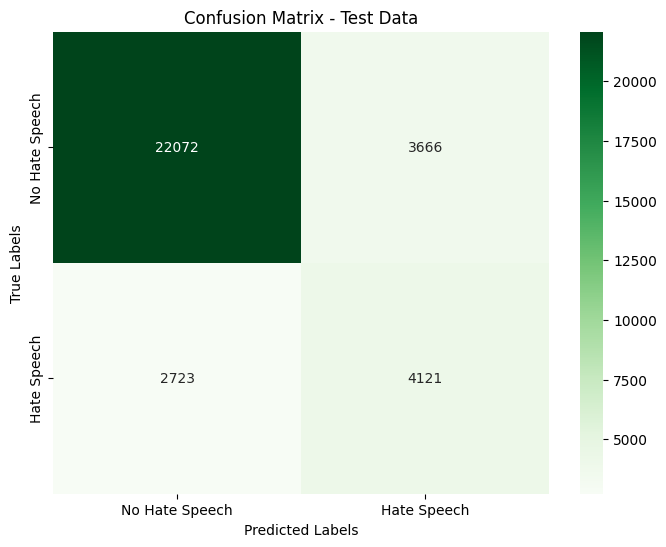

In [43]:
X_train_token,X_val_token,y_train_token,y_val_token, X_test_token, y_test_token, tokenizer = tokenize_and_split_data(X_mixed_train_data, y_mixed_train_data, X_mixed_test_data, y_mixed_test_data)
glove_embedding_matrix = load_embeddings('drive/MyDrive/Colab Notebooks/data/embeddings/glove.twitter.27B.200d.txt', 200, tokenizer.word_index)
model, history = train_gru(X_train_token, y_train_token, X_val_token, y_val_token, len(tokenizer.word_index)+1, 40, glove_embedding_matrix, embedding_dim=200, epochs=20, batch_size=32)
evaluate_on_val(model, history, X_val_token, y_val_token)
evaluate_on_test(model, X_test_token, y_test_token)

In [44]:
model.save("drive/MyDrive/Colab Notebooks/models/gru/mixed/gru-model_mixed-dataset.keras")

with open("drive/MyDrive/Colab Notebooks/models/gru/mixed/tokenizer_mixed-dataset.pkl", 'wb') as f:
    pickle.dump(tokenizer, f)


## Verwendung der Modelle (+tokenizer)

In [ ]:
# Modelle & Tokenizer laden
model_old = load_model("drive/MyDrive/Colab Notebooks/models/gru/old/gru-model_old-dataset.keras")
model_new = load_model("drive/MyDrive/Colab Notebooks/models/gru/new/gru-model_new-dataset.keras")
model_mixed = load_model("drive/MyDrive/Colab Notebooks/models/gru/mixed/gru-model_mixed-dataset.keras")

with open("drive/MyDrive/Colab Notebooks/models/gru/old/tokenizer_old-dataset.pkl", 'rb') as f:
    tokenizer_old = pickle.load(f)

with open("drive/MyDrive/Colab Notebooks/models/gru/new/tokenizer_new-dataset.pkl", 'rb') as f:
    tokenizer_new = pickle.load(f)

with open("drive/MyDrive/Colab Notebooks/models/gru/mixed/tokenizer_mixed-dataset.pkl", 'rb') as f:
    tokenizer_mixed = pickle.load(f)

In [ ]:
# Hilfsfunktion zur Tokenisierung, Padding und Vorhersage
def predict_tweet(model, tokenizer, tweet, max_len=40):
    tweet_seq = tokenizer.texts_to_sequences([tweet])
    tweet_padded = pad_sequences(tweet_seq, padding='post', maxlen=max_len)
    prediction = model.predict(tweet_padded)[0][0]
    label = "Hate-Speech" if prediction >= 0.5 else "No Hate-Speech"
    return label, prediction


def predict_dataset(model, tokenizer, X, y, max_len=40):
    X = [str(x) for x in X]
    X_seq = tokenizer.texts_to_sequences(X)
    X_pad = pad_sequences(X_seq, padding='post', maxlen=max_len)
    y_pred_prob = model.predict(X_pad)
    y_pred = (y_pred_prob >= 0.5).astype(int).flatten()
    recall = recall_score(y, y_pred)
    f1 = f1_score(y, y_pred)
    accuracy = accuracy_score(y, y_pred)
    cm = confusion_matrix(y, y_pred)
    print("Recall:", recall)
    print("F1 Score:", f1)
    print("Accuracy:", accuracy)
    print("Confusion Matrix:\n", cm)

In [ ]:
example_tweets = [
    "yeah, heres a clue for the nigger author of this article. Chinks hate niggers, Kikes hate niggers, Spicks hate niggers and Towelheads hate niggers. EVen niggers hate niggers. Black Africans hate the gauche lazy American blacks because they have no morals or work ethic. Niggrus Americanus is the lowest form of human (if you can even call them that) on the planet, we should erase them",  # Hate Speech
    "Hope you have a great day! Stay positive!"  # Kein Hate Speech
]

for tweet in example_tweets:
    print(f"\nTweet: {tweet}")

    label_old, pred_old = predict_tweet(model_old, tokenizer_old, tweet)
    label_new, pred_new = predict_tweet(model_new, tokenizer_new, tweet)
    label_mixed, pred_mixed = predict_tweet(model_mixed, tokenizer_mixed, tweet)

    print(f"🔹 **Old Model:** {label_old} (Confidence: {pred_old:.4f})")
    print(f"🔹 **New Model:** {label_new} (Confidence: {pred_new:.4f})")
    print(f"🔹 **Mixed Model:** {label_mixed} (Confidence: {pred_mixed:.4f})")


Tweet: yeah, heres a clue for the nigger author of this article. Chinks hate niggers, Kikes hate niggers, Spicks hate niggers and Towelheads hate niggers. EVen niggers hate niggers. Black Africans hate the gauche lazy American blacks because they have no morals or work ethic. Niggrus Americanus is the lowest form of human (if you can even call them that) on the planet, we should erase them
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 106ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 102ms/step
🔹 **Old Model:** Hate-Speech (Confidence: 0.8515)
🔹 **New Model:** Hate-Speech (Confidence: 0.9858)
🔹 **Mixed Model:** Hate-Speech (Confidence: 0.9996)

Tweet: Hope you have a great day! Stay positive!
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
🔹 **Old Model:** No Hate-Speech (Confidence: 0.0000)
🔹 **New Model:** No Hate-Speech (Confidence: 0.0036)
🔹 **Mixed Model:** No Hate-Speech (Confidence: 0.0000)


In [ ]:
predict_dataset(model_mixed, tokenizer_mixed, X_mixed_test_data, y_mixed_test_data)